In [2]:
from transformers import FlaxAutoModelForSeq2SeqLM
from transformers import AutoTokenizer

MODEL_NAME_OR_PATH = "flax-community/t5-recipe-generation"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_OR_PATH, use_fast=True)
model = FlaxAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME_OR_PATH)

prefix = "items: "
# generation_kwargs = {
#     "max_length": 512,
#     "min_length": 64,
#     "no_repeat_ngram_size": 3,
#     "early_stopping": True,
#     "num_beams": 5,
#     "length_penalty": 1.5,
# }
generation_kwargs = {
    "max_length": 512,
    "min_length": 64,
    "no_repeat_ngram_size": 3,
    "do_sample": True,
    "top_k": 60,
    "top_p": 0.95
}


special_tokens = tokenizer.all_special_tokens
tokens_map = {
    "<sep>": "--",
    "<section>": "\n"
}
def skip_special_tokens(text, special_tokens):
    for token in special_tokens:
        text = text.replace(token, "")

    return text

def target_postprocessing(texts, special_tokens):
    if not isinstance(texts, list):
        texts = [texts]

    new_texts = []
    for text in texts:
        text = skip_special_tokens(text, special_tokens)

        for k, v in tokens_map.items():
            text = text.replace(k, v)

        new_texts.append(text)

    return new_texts

def generation_function(texts):
    _inputs = texts if isinstance(texts, list) else [texts]
    inputs = [prefix + inp for inp in _inputs]
    inputs = tokenizer(
        inputs,
        max_length=256,
        padding="max_length",
        truncation=True,
        return_tensors="jax"
    )

    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    output_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        **generation_kwargs
    )
    generated = output_ids.sequences
    generated_recipe = target_postprocessing(
        tokenizer.batch_decode(generated, skip_special_tokens=False),
        special_tokens
    )
    return generated_recipe


In [3]:
items = [
    "macaroni, butter, salt, bacon, milk, flour, pepper, cream corn",
    "provolone cheese, bacon, bread, ginger"
]
generated = generation_function(items)
for text in generated:
    sections = text.split("\n")
    for section in sections:
        section = section.strip()
        if section.startswith("title:"):
            section = section.replace("title:", "")
            headline = "TITLE"
        elif section.startswith("ingredients:"):
            section = section.replace("ingredients:", "")
            headline = "INGREDIENTS"
        elif section.startswith("directions:"):
            section = section.replace("directions:", "")
            headline = "DIRECTIONS"

        if headline == "TITLE":
            print(f"[{headline}]: {section.strip().capitalize()}")
        else:
            section_info = [f"  - {i+1}: {info.strip().capitalize()}" for i, info in enumerate(section.split("--"))]
            print(f"[{headline}]:")
            print("\n".join(section_info))

    print("-" * 130)


[TITLE]: Mom s mac n cheese
[INGREDIENTS]:
  - 1: 2 cups macaroni
  - 2: 1 tablespoon butter
  - 3: 1 teaspoon salt
  - 4: 6 pieces bacon
  - 5: 4 cups milk
  - 6: 1 cup flour
  - 7: 14 teaspoon pepper
  - 8: 1 9 ounce can cream corn
  - 9: 1 cup cheez whiz
[DIRECTIONS]:
  - 1: Cook macaroni according to package directions drain.
  - 2: Melt butter in a medium sauce pot over low heat.
  - 3: Stir in flour and salt until smooth.
  - 4: Add 2 cups milk and cook over medium heat, stirring constantly until it boils and thickens.
  - 5: Continue to cook for 10 minutes or until smooth.
  - 6: Stir in cream corn, salt, pepper, and cheez whiz.
  - 7: Add cooked macaroni and bacon.
  - 8: Toss together until coated.
----------------------------------------------------------------------------------------------------------------------------------
[TITLE]: Hot dog pizza
[INGREDIENTS]:
  - 1: 1 lb hot dog
  - 2: Provolone cheese
  - 3: 12 slices bacon, cooked and crumbled
  - 4: 6 slices multigrain

In [8]:
print(generated)

[' title: chocolate ruffles\n ingredients: 1 sq. baker s german s sweet chocolate-- 1/2 tbsp. butter or margarine-- 1 pkg. hershey s german s sweet and sour mini chocolate ruffles with chilies\n directions: melt chocolate and butter in a double boiler until smooth.-- dip chicken in chocolate and put on foil lined cookie sheet.-- chill for 15 minutes or until chocolate cools and hardens.']


In [4]:
items = [
    "chocolate, butter,chicken",
]
generated = generation_function(items)
for text in generated:
    sections = text.split("\n")
    for section in sections:
        section = section.strip()
        if section.startswith("title:"):
            section = section.replace("title:", "")
            headline = "TITLE"
        elif section.startswith("ingredients:"):
            section = section.replace("ingredients:", "")
            headline = "INGREDIENTS"
        elif section.startswith("directions:"):
            section = section.replace("directions:", "")
            headline = "DIRECTIONS"

        if headline == "TITLE":
            print(f"[{headline}]: {section.strip().capitalize()}")
        else:
            section_info = [f"  - {i+1}: {info.strip().capitalize()}" for i, info in enumerate(section.split("--"))]
            print(f"[{headline}]:")
            print("\n".join(section_info))

    print("-" * 130)

[TITLE]: Chocolate ruffles
[INGREDIENTS]:
  - 1: 1 sq. baker s german s sweet chocolate
  - 2: 1/2 tbsp. butter or margarine
  - 3: 1 pkg. hershey s german s sweet and sour mini chocolate ruffles with chilies
[DIRECTIONS]:
  - 1: Melt chocolate and butter in a double boiler until smooth.
  - 2: Dip chicken in chocolate and put on foil lined cookie sheet.
  - 3: Chill for 15 minutes or until chocolate cools and hardens.
----------------------------------------------------------------------------------------------------------------------------------


In [5]:
from gradio_client import Client

client = Client("https://playgroundai-playground-v2-5.hf.space/--replicas/o9oxl/")
result = client.predict(
        "Mac n cheese", # str  in 'Promp'Textbox component
        " ",    # str  in 'Negative prompt' Textbox component
        False,  # bool  in 'Use negative prompt' Checkbox component
        376603080,  # float (numeric value between 0 and 2147483647) in 'Seed' Slider component
        1024,   # float (numeric value between 256 and 1536) in 'Width' Slider component
        1024,   # float (numeric value between 256 and 1536) in 'Height' Slider component
        3,  # float (numeric value between 0.1 and 20) in 'Guidance Scale' Slider component
        True,   # bool  in 'Randomize seed' Checkbox component
                            api_name="/run"
)
print(result)

Loaded as API: https://playgroundai-playground-v2-5.hf.space/--replicas/o9oxl/ ✔
([{'image': '/private/var/folders/6k/47szr19n3q9b475tdmrfp68h0000gn/T/gradio/ca390091beca72d14c7e715b6d00019ed017c0cd/7a0602a6-b2ad-476c-8a3c-b6d38d43b980.png', 'caption': None}], 809838988)


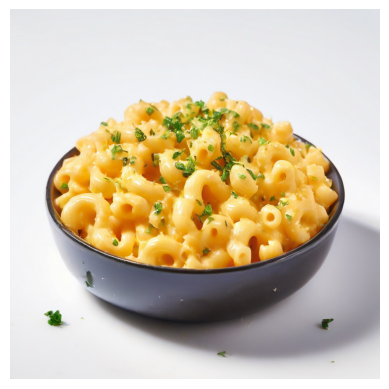

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "/private/var/folders/6k/47szr19n3q9b475tdmrfp68h0000gn/T/gradio/5788e4c3600ebdbde2c1a51aa16d66fcac2d295d/884f7f27-2b30-4193-bd35-784144e9b0a4.png"  # Replace this with the actual path to your image file

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()


Loaded as API: https://playgroundai-playground-v2-5.hf.space/--replicas/o9oxl/ ✔


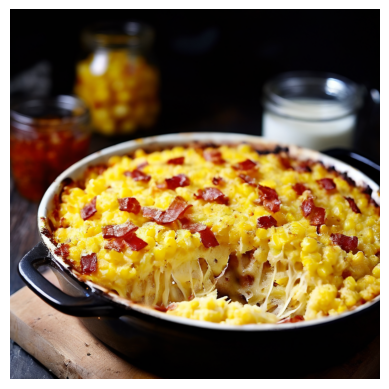

([{'image': '/private/var/folders/6k/47szr19n3q9b475tdmrfp68h0000gn/T/gradio/58669e98802a7390a4660ecae81ecb50c9ca9398/13c48085-25c1-49fb-a771-eda7949f3dfc.png', 'caption': None}], 137962396)


In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from gradio_client import Client


items = [
    "macaroni, butter, salt, bacon, milk, flour, pepper, cream corn",
]
recipe = generation_function(items)

# Making API request using gradio_client
client = Client("https://playgroundai-playground-v2-5.hf.space/--replicas/o9oxl/")
result = client.predict(
        recipe, # str  in 'Promp'Textbox component
        " ",    # str  in 'Negative prompt' Textbox component
        False,  # bool  in 'Use negative prompt' Checkbox component
        376603080,  # float (numeric value between 0 and 2147483647) in 'Seed' Slider component
        1024,   # float (numeric value between 256 and 1536) in 'Width' Slider component
        1024,   # float (numeric value between 256 and 1536) in 'Height' Slider component
        3,  # float (numeric value between 0.1 and 20) in 'Guidance Scale' Slider component
        True,   # bool  in 'Randomize seed' Checkbox component
        api_name="/run"
)

# Extracting image path from the result
image_path = result[0][0]['image']

# Load and display the image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

print(result)


In [13]:
print(recipe)

[' title: corn casserole\n ingredients: 1 1/2 c. macaroni-- 2 tbsp. butter or margarine-- 1/2 tsp. salt-- 4 strips bacon-- 2 c. milk-- 2 tbsp. flour-- 1/4 tsp. pepper-- 2 cans cream corn\n directions: cook macaroni until tender.-- saute bacon and pour off excess drippings.-- stir in flour and salt and pepper.-- add milk.-- cook until thickened.-- add cream corn and macaroni.-- pour in casserole dish and sprinkle with bacon.-- bake at 350 until bubbly.']


In [10]:
print(image_path)

/private/var/folders/6k/47szr19n3q9b475tdmrfp68h0000gn/T/gradio/db583a61fbb0fbb298cb9384f0dcc58d2f7bc9fc/e641efd4-2fdb-4bc9-ab84-c1505a0ebb21.png


In [14]:
for text in recipe:
    sections = text.split("\n")
    for section in sections:
        section = section.strip()
        if section.startswith("title:"):
            section = section.replace("title:", "")
            headline = "TITLE"
        elif section.startswith("ingredients:"):
            section = section.replace("ingredients:", "")
            headline = "INGREDIENTS"
        elif section.startswith("directions:"):
            section = section.replace("directions:", "")
            headline = "DIRECTIONS"

        if headline == "TITLE":
            print(f"[{headline}]: {section.strip().capitalize()}")
        else:
            section_info = [f"  - {i+1}: {info.strip().capitalize()}" for i, info in enumerate(section.split("--"))]
            print(f"[{headline}]:")
            print("\n".join(section_info))

    print("-" * 130)

[TITLE]: Corn casserole
[INGREDIENTS]:
  - 1: 1 1/2 c. macaroni
  - 2: 2 tbsp. butter or margarine
  - 3: 1/2 tsp. salt
  - 4: 4 strips bacon
  - 5: 2 c. milk
  - 6: 2 tbsp. flour
  - 7: 1/4 tsp. pepper
  - 8: 2 cans cream corn
[DIRECTIONS]:
  - 1: Cook macaroni until tender.
  - 2: Saute bacon and pour off excess drippings.
  - 3: Stir in flour and salt and pepper.
  - 4: Add milk.
  - 5: Cook until thickened.
  - 6: Add cream corn and macaroni.
  - 7: Pour in casserole dish and sprinkle with bacon.
  - 8: Bake at 350 until bubbly.
----------------------------------------------------------------------------------------------------------------------------------
